# Univariate volatility Modelling 

In econometrics, risk is characterised by volatility of returns, which is characterised by variance or standard deviation of returns.

Autoregressive models can be developed for univariate time series data that is stationary. In time series where the variance is increasing in a systematic way, such as an increasing trend, this property of the series is called heteroskedasticity.

When the variance of a time-series process is not consistent, to model the data, it becomes imperative to model the conditional expectation and conditional variance of the data generating process. This notebook deals with methods to model the volatility of a time series.

The various univariate volatility models include Auto Regressive Conditional Heteroscdastic (ARCH) Model and Generalized Auto Regressive Conditional Heteroscdastic (GARCH) Model, and other improvisations of the GARCH model.

## Auto Regressive Conditional Heteroscdastic (ARCH) Model
ARCH (autoregressive conditionally heteroscedastic) model is a model for the variance of a time series. ARCH models are used to describe a changing, possibly volatile variance.

As an example we use the ARCH(1) process.
### ARCH(1)
If we are modelling the volatility of a series $y_t$.
We assume that an AR(1) process is sufficient to capture the time series properties of the mean of the process.
$$ y_t = a_0 + a_1 y_{t-1} + u_t $$
We still assume the expectation of the error terms is zero, so its only the variance that deviates from zero. 
$$ \mathbb{E}_t (u_t) = \mathbb{E}_{t-1}(u_t) = 0 $$

For the model of the conditional mean to be consistent, we require the level of the errors to be uncorrelated over time:
$$ \mathbb{E} (u_t u_{t-s}) = 0$$
We allow the conditional variance $\mathbb{E}_t(u_t ^2)=\sigma_t ^2$ to be auto-correlated.

> ARCH models are mean zero, serially uncorrelated processes with nonconstant variances conditional on the past, but constant unconditional variances. For such processes, the recent past gives information about the one-period forecast variance.
 
<center> – Autoregressive Conditional Heteroscedasticity with Estimates of the Variance of United Kingdom Inflation, 1982. </center>

Under the ARCH(1) model, the residual term can be expressed as

$$ u_t = \epsilon_t \sqrt{\omega + \alpha_1 u_{t-1} ^2} $$

where $\epsilon_t$ is white noise that is independent of $u_t$ with variance 1. 

The period $t-1$ conditional variance for $u_t$ is 
$$\begin{align} 
\mathbb{E}_{t-1} (u_t ^2) &= \mathbb{E}_{t-1} ((\epsilon_t \sqrt{\omega + \alpha_1 u_{t-1} ^2})^2) \\ 
&= \sigma_{\epsilon} ^2 ( \omega + \alpha_1 \mathbb{E}_{t-1} (u_{t-1} ^2 )) \\
&=  \omega + \alpha_1 u_{t-1} ^2
\end{align}$$

and the unconditional variance is given by,
$$\begin{align} 
\mathbb{E} (u_t ^2) &= \mathbb{E} ((\epsilon_t \sqrt{\omega + \alpha_1 u_{t-1} ^2})^2) \\ 
&=  ( \omega + \alpha_1 \mathbb{E} (u_{t-1} ^2 )) \\
&=  \frac{\omega}{1 - \alpha_1}
\end{align}$$

### ARCH(p) process
The residual term can be expressed as

$$ u_t = \epsilon_t \sqrt{\omega + \alpha_1 u_{t-1} ^2 + \alpha_2 u_{t-2} ^2 + \textrm{...} + \alpha_p u_{t-p} ^2} $$


## Generalized Auto Regressive Conditional Heteroscdastic (GARCH) Model 

In the GARCH process we assume that the conditional variance follows ARMA(p,q) process. Mathematically we express this as:
$$ u_t = \epsilon_t \sqrt{h_t} $$,
where
$$ h_t = \omega + \alpha_1 u_{t-1} ^2 + \alpha_2 u_{t-2} ^2 + \textrm{...} + \alpha_p u_{t-p} ^2 + \beta_1 h_{t-1} + \beta_2 h_{t-2} +  \textrm{ ... } + \beta_q h_{t-q} $$
$\alpha$ is the reaction parameter. High alpha corresponds to spiky or nervous market and low alpha corresponds to stable market.
$\beta$ is volatility persistence. High beta implies high persistence leading to volatility clustering.
Low alpha is usually associated with high beta and vice versa. 
$\frac{\omega}{1-\alpha-\beta}$ is the unconditional variance. 

Generalized Autoregressive Conditional Heteroskedasticity, or GARCH, is an extension of the ARCH model that incorporates a moving average component together with the autoregressive component.

Specifically, the model includes lag variance terms (e.g. the observations if modeling the white noise residual errors of another process), together with lag residual errors from a mean process.

The introduction of a moving average component allows the model to both model the conditional change in variance over time as well as changes in the time-dependent variance.

In order to find the perfect process to model the volatility we look at the ACF - PACF plots for the squared process.

> If a correlogram appears to be white noise , then volatility ca be detected by looking at the correlogram of the squared values since the squared values are equivalent to the variance (provided the series is adjusted to have a mean of zero).

— Pages 146-147, Introductory Time Series with R, 2009.

The ACF and PACF plots can then be interpreted to estimate values for p and q, in a similar way as is done for the ARMA model.

# Next we simulate a GARCH process

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess

def garch(ar, ω, α, β, n_out=1000):
    p = len(α)
    q = len(β)

    # Since the first max(p, q) number of points are not generated from the garch
    # process, the first points are garbage (possibly extending beyond max(p, q)),
    # so we drop n_pre > max(p, q) number of points.
    n_pre = np.max([p, q])+1;
    n = n_pre + n_out

    # Sample noise
    ɛ = np.random.normal(0, 1, n)

    y = ArmaProcess.from_coeffs(np.array(ar), np.array([1])).generate_sample(nsample=n)
    σ = np.zeros(n)

    
    # Pre-populate first max(p, q) values, because they are needed in the iteration.
    for k in range(np.max([p, q])):
        σ[k] = np.random.normal(0, 1)
        y[k] = y[k] + σ[k] * ɛ[k]

    for k in range(np.max([p, q]), n):
        α_term = sum([α[i] * y[k-i]**2 for i in range(p)])
        β_term = sum([β[i] * σ[k-i]**2 for i in range(q)])
        σ[k] = np.sqrt(ω + α_term + β_term)
        y[k] = y[k] + σ[k] * ɛ[k]

    return y[n_pre:]

ar=[0.5,0.2,-0.1]
ω = 0.001
α = [0.3,0.2]
β = [0.2,0.1]

y = garch(ar, ω, α, β, n_out=500)
x = range(len(y))

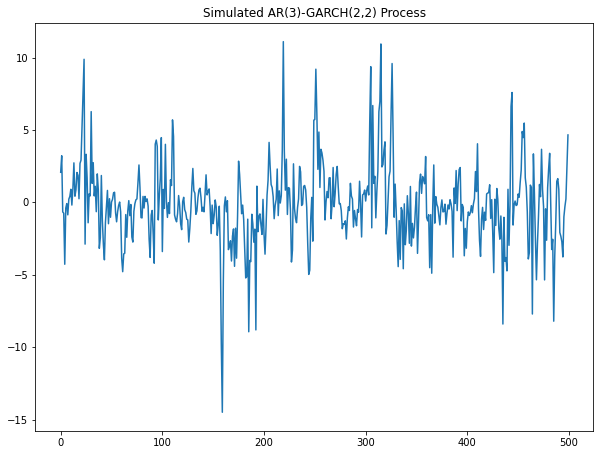

In [2]:
plt.figure(figsize=[10, 7.5]); # Set dimensions for figure
plt.plot(y)
plt.title("Simulated AR(3)-GARCH(2,2) Process")
plt.show()

In [3]:
squared_y = [x**2 for x in y]

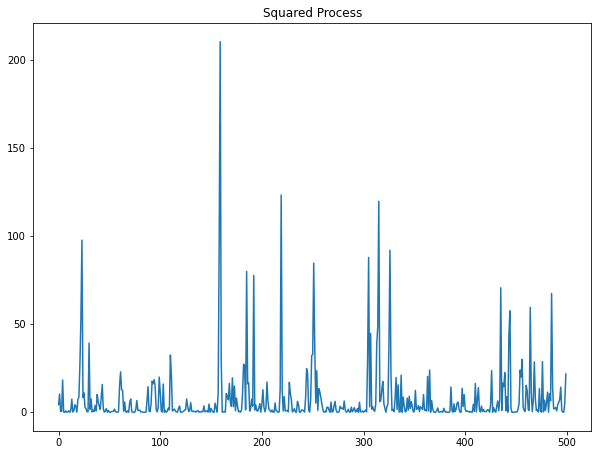

In [4]:
plt.figure(figsize=[10, 7.5]); # Set dimensions for figure
plt.plot(squared_y)
plt.title("Squared Process")
plt.show()

In [5]:
from statsmodels.graphics.tsaplots import plot_pacf                 #Used to Plot PACF plot.
from statsmodels.graphics.tsaplots import plot_acf                  #Used to Plot ACF plot.

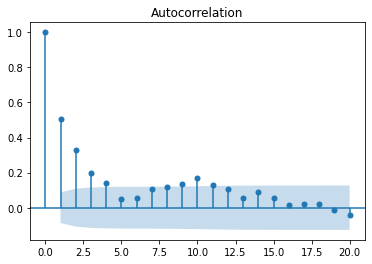

In [6]:
plot_acf(y,lags=20)
plt.show()

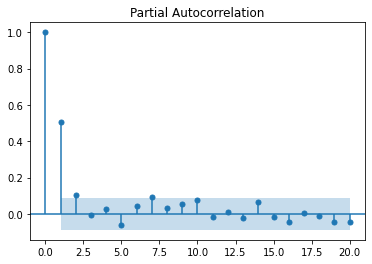

In [7]:
plot_pacf(y,lags=20)
plt.show()

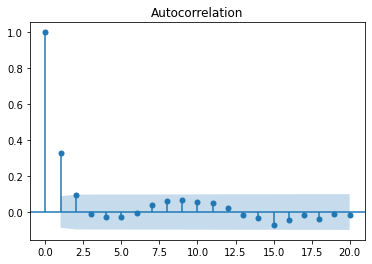

In [8]:
plot_acf(squared_y,lags=20)
plt.show()

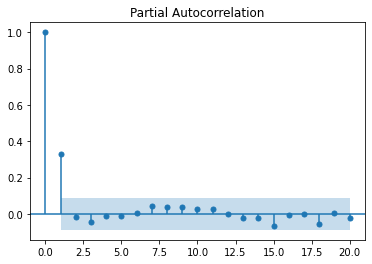

In [9]:
plot_pacf(squared_y,lags=20)
plt.show()

In [26]:
from arch import arch_model
model = arch_model(y, mean='Zero', vol='GARCH', p=2, q=2, dist="Normal")
model_fit = model.fit()
print(model_fit.summary)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1186.032418633662
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1174.1041736565767
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1172.781085188864
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1164.621000792475
Iteration:      5,   Func. Count:     39,   Neg. LLF: 1161.3758322288809
Iteration:      6,   Func. Count:     47,   Neg. LLF: 1159.6430275272132
Iteration:      7,   Func. Count:     54,   Neg. LLF: 1157.841555214878
Iteration:      8,   Func. Count:     62,   Neg. LLF: 1157.7972185483777
Iteration:      9,   Func. Count:     69,   Neg. LLF: 1157.7772203369298
Iteration:     10,   Func. Count:     76,   Neg. LLF: 1157.757181508272
Iteration:     11,   Func. Count:     83,   Neg. LLF: 1157.7562287216351
Iteration:     12,   Func. Count:     90,   Neg. LLF: 1157.7558935259487
Iteration:     13,   Func. Count:     97,   Neg. LLF: 1157.7558645319023
Iteration:     14,   Func. Count:    104,   Neg. LLF: 11